# Generate Convolutional Layers by Splatting Gaussians

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import glm
import math
import dataclasses
import matplotlib.pyplot as plt
import diff_gaussian_rasterization_batched as dgrb

In [2]:
device = torch.device("cuda")

In [3]:
@dataclasses.dataclass
class GaussianSplattingRendererConfig:
    fov: float
    img_size: int
    img_channels: int
    img_height: int
    img_width: int
    projection_matrix: torch.Tensor

class GaussianSplattingRenderer(nn.Module):
    def __init__(self, config: GaussianSplattingRendererConfig):
        super().__init__()
        self.config = config
        self.renderer = dgrb.GaussianRasterizer(
            dgrb.GaussianRasterizationSettings(
                image_channels=config.img_channels,
                image_height=config.img_size,
                image_width=config.img_size,
                tanfovx=math.tan(config.fov * 0.5),
                tanfovy=math.tan(config.fov * 0.5),
                bg=torch.zeros(config.img_channels, dtype=torch.float32, device=device),
                scale_modifier=1.0,
                projmatrix=config.projection_matrix,
                sh_degree=1,
                campos=torch.tensor([0, 0, 0], dtype=torch.float32, device=device),
                prefiltered=False,
                debug=True,
            )
        )
    
    def forward(self, g_mean: torch.Tensor, g_scale: torch.Tensor, g_quat: torch.Tensor, g_color: torch.Tensor, view_matrix: torch.Tensor) -> torch.Tensor:
        B, N, _ = g_mean.shape
        assert g_mean.shape == (B, N, 3)
        assert g_scale.shape == (B, N, 3)
        assert g_quat.shape == (B, N, 4)
        assert g_color.shape == (B, N, self.config.img_channels)
        assert view_matrix.shape == (B, 4, 4)

        # normalize quaternions
        g_quat = F.normalize(g_quat, dim=2)

        # [B, config.img_channels, H, W]
        rendered_image, _ = self.renderer(
            means3D=g_mean,
            means2D=torch.zeros(B, N, 2, dtype=torch.float32, device=device),
            colors_precomp=g_color,
            opacities=torch.ones(B, N, 1, dtype=torch.float32, device=device),
            scales=g_scale,
            rotations=g_quat,
            viewmatrixes=view_matrix,
        )

        return rendered_image


In [4]:
def random_point_on_sphere(r: float) -> list[float]:
    phi = torch.rand(1).item() * 2 * math.pi
    theta = torch.rand(1).item() * math.pi
    return [
        r * math.sin(theta) * math.cos(phi),
        r * math.sin(theta) * math.sin(phi),
        r * math.cos(theta),
    ]


def toTensor(m: glm.mat4) -> torch.Tensor:
    return torch.tensor(m.to_list(), dtype=torch.float32, device=device)


class GaussianSplattingLayer(nn.Module):
    # Field of view of each camera
    FOV = math.radians(90.0)

    # distance from the camera to the origin
    CAM_DISTANCE = 5.0

    def __init__(
        self, in_channels: int, out_channels: int, filter_size: int, n_gaussians: int
    ):
        super().__init__()
        self.filter_size = filter_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_gaussians = n_gaussians

        # constructs a renderer
        # assuming the points are in the box [-1 1]^3,
        # and using a FOV of 60 and a distance of 3,
        # then the points they should just about fill the viewport
        self.renderer = GaussianSplattingRenderer(
            GaussianSplattingRendererConfig(
                fov=self.FOV,
                img_size=self.filter_size,
                img_channels=self.in_channels,
                img_height=self.filter_size,
                img_width=self.filter_size,
                projection_matrix=toTensor(glm.perspective(self.FOV, 1.0, 0.1, 20.0)),
            )
        )

        # fixed camera positions (should be learnable later on)
        # camera_viewmatrices in (out_channels, 4, 4)
        self.camera_viewmatrices = torch.stack(
            [
                toTensor(
                    glm.scale([1, 1, -1])
                    * glm.lookAt(
                        random_point_on_sphere(self.CAM_DISTANCE),
                        [0, 0, 0],
                        [0, 1, 0],
                    )
                )
                for _ in range(out_channels)
            ]
        )

        # Learnable weights

        # g_mean in (n_gaussians, 3)
        self.g_mean = nn.Parameter(
            torch.randn(n_gaussians, 3, device=device) * 2 - 1, requires_grad=True
        )
        # g_scales in (n_gaussians, 3)
        self.g_scales = nn.Parameter(
            torch.ones(n_gaussians, 3, device=device) * 0.1, requires_grad=True
        )
        # g_quats in (n_gaussians, 4)
        self.g_quats = nn.Parameter(
            torch.randn(n_gaussians, 4, device=device), requires_grad=True
        )
        # g_colors in (n_gaussians, in_channels)
        self.g_colors = nn.Parameter(
            torch.randn(n_gaussians, in_channels, device=device),
            requires_grad=True,
        )

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        # image has shape (B, in_channels, H, W)
        B, _, H, W = image.shape
        assert image.shape == (B, self.in_channels, H, W)

        # construct the kernel

        # kernel in (out_channels, in_channels, filter_size, filter_size)
        kernel = self.renderer(
            self.g_mean.expand(self.out_channels, self.n_gaussians, 3),
            self.g_scales.expand(self.out_channels, self.n_gaussians, 3),
            self.g_quats.expand(self.out_channels, self.n_gaussians, 4),
            self.g_colors.expand(self.out_channels, self.n_gaussians, self.in_channels),
            self.camera_viewmatrices,
        )

        # out in (B, out_channels, H, W)
        out = F.conv2d(image, kernel, padding="same")

        return out

In [5]:
class Cifar10Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 9, padding='same')
        self.conv1_bn = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 9, padding='same')
        self.conv2_bn = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 9, padding='same')
        self.conv3_bn = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def train_conv_classifier(
        model: Cifar10Classifier,
        optimizer: torch.optim.Optimizer,
        images: torch.Tensor,
        labels: torch.Tensor,
) -> float:
    # images in (B, 3, 64, 64)
    images = images.to(device)
    # labels in (B)
    labels = labels.to(device)
    # train
    model.train()
    optimizer.zero_grad()
    output = model(images)
    loss = F.cross_entropy(output, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

In [6]:
class Cifar10ClassifierGaussian(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GaussianSplattingLayer(3, 8, 31, 100)
        self.conv1_bn = nn.BatchNorm2d(8)
        self.conv2 = GaussianSplattingLayer(8, 16, 31, 100)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.conv3 = GaussianSplattingLayer(16, 32, 31, 100)
        self.conv3_bn = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(32 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def train_gaussian_classifier(
        model: Cifar10ClassifierGaussian,
        optimizer: torch.optim.Optimizer,
        images: torch.Tensor,
        labels: torch.Tensor,
) -> float:
    # images in (B, 3, 64, 64)
    images = images.to(device)
    # labels in (B)
    labels = labels.to(device)
    # train
    model.train()
    optimizer.zero_grad()
    output = model(images)
    loss = F.cross_entropy(output, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

In [7]:
# download mnist dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.CIFAR10('data', download=True, train=True, transform=transform)
testset = datasets.CIFAR10('data', download=True, train=False, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# create conv model
conv_model = Cifar10Classifier().to(device)
conv_optim = torch.optim.Adam(conv_model.parameters(), lr=2e-5)

conv_losses = []

# create gaussian model
gaussian_model = Cifar10ClassifierGaussian().to(device)
gaussian_optim = torch.optim.Adam(gaussian_model.parameters(), lr=2e-5)

gaussian_losses = []

Files already downloaded and verified
Files already downloaded and verified


In [22]:
# train model
for epoch in range(3):
    print(f"Epoch {epoch}")
    for i, (images, labels) in enumerate(tqdm(trainloader)):
        loss = train_conv_classifier(conv_model, conv_optim, images, labels)
        conv_losses.append(loss)
    print(f"Loss: {loss}")

Epoch 0


100%|██████████| 782/782 [00:30<00:00, 25.99it/s]


Loss: 1.4012620449066162
Epoch 1


100%|██████████| 782/782 [00:30<00:00, 25.51it/s]


Loss: 0.8052617907524109
Epoch 2


100%|██████████| 782/782 [00:31<00:00, 25.14it/s]

Loss: 0.9362212419509888


In [10]:
print(gaussian_model.conv1.g_mean)

Parameter containing:
tensor([[-2.7657, -2.3328, -4.4871],
        [-1.8191,  0.1413,  0.4938],
        [-3.0348,  0.1936, -3.0263],
        [-5.8448, -1.2259, -0.8855],
        [ 0.1336, -1.4033, -0.9180],
        [-2.5116, -1.1946, -4.2357],
        [-1.3504, -1.5271, -2.5188],
        [-2.7306, -3.4720, -0.9922],
        [-0.1237,  1.4832, -0.7682],
        [-4.2672, -1.5820, -3.5444],
        [-2.4719, -0.5065,  0.2549],
        [-0.9452,  0.4579, -2.1687],
        [-1.1037, -0.5096, -5.2754],
        [-3.4691, -4.3453, -3.1464],
        [-3.7613,  1.1869, -1.8067],
        [-4.7754, -0.5783, -2.9144],
        [-3.2294, -1.9674, -0.7768],
        [-1.8275, -3.8728, -1.4521],
        [-1.0280,  2.7581,  0.1026],
        [-3.7084, -1.7162, -2.0735],
        [-1.8997, -1.4339, -0.1940],
        [-4.9826, -4.2781, -3.5845],
        [ 0.0243, -2.9501, -2.9205],
        [-1.1469,  0.0651, -2.0579],
        [ 0.1045,  0.1260, -0.7374],
        [ 0.7833,  0.0889, -4.3864],
        [-1.9610

In [15]:
# train model
for epoch in range(3):
    print(f"Epoch {epoch}")
    for i, (images, labels) in enumerate(tqdm(trainloader)):
        loss = train_gaussian_classifier(gaussian_model, gaussian_optim, images, labels)
        gaussian_losses.append(loss)
    print(f"Loss: {loss}")

Epoch 0


100%|██████████| 782/782 [07:38<00:00,  1.71it/s]


Loss: 1.2597942352294922
Epoch 1


100%|██████████| 782/782 [07:28<00:00,  1.74it/s]


Loss: 1.0020619630813599
Epoch 2


 19%|█▉        | 149/782 [01:28<06:14,  1.69it/s]


KeyboardInterrupt: 

In [16]:
print(gaussian_model.conv1.g_mean)

Parameter containing:
tensor([[-2.7494, -2.3320, -4.5008],
        [-1.8191,  0.1359,  0.4944],
        [-3.0229,  0.1979, -3.0404],
        [-5.8347, -1.2155, -0.8967],
        [ 0.1430, -1.4176, -0.9027],
        [-2.5242, -1.1861, -4.2307],
        [-1.3396, -1.5322, -2.5195],
        [-2.7338, -3.4590, -1.0038],
        [-0.1299,  1.4816, -0.7692],
        [-4.2723, -1.5919, -3.5371],
        [-2.4889, -0.5260,  0.2367],
        [-0.9584,  0.4545, -2.1569],
        [-1.1130, -0.5147, -5.2615],
        [-3.4609, -4.3480, -3.1491],
        [-3.7522,  1.1787, -1.8161],
        [-4.7626, -0.5562, -2.9282],
        [-3.2372, -1.9611, -0.7740],
        [-1.8281, -3.8894, -1.4358],
        [-1.0283,  2.7556,  0.1046],
        [-3.7185, -1.7096, -2.0711],
        [-1.8869, -1.4284, -0.2058],
        [-4.9802, -4.2675, -3.5889],
        [ 0.0254, -2.9507, -2.9196],
        [-1.1279,  0.0764, -2.0784],
        [ 0.1064,  0.1427, -0.7230],
        [ 0.7916,  0.0884, -4.3833],
        [-1.9614

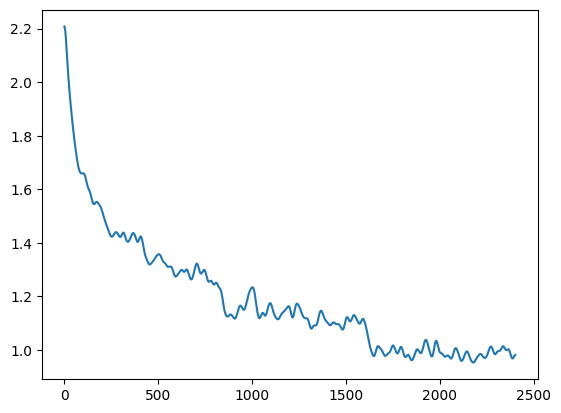

In [23]:
from scipy.ndimage import gaussian_filter

losses_smoothed = gaussian_filter(conv_losses, sigma=10)

plt.plot(losses_smoothed)

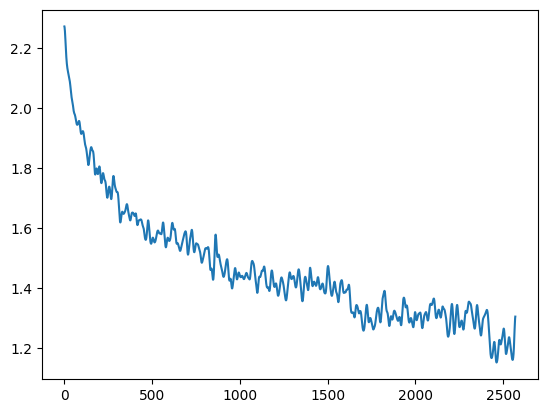

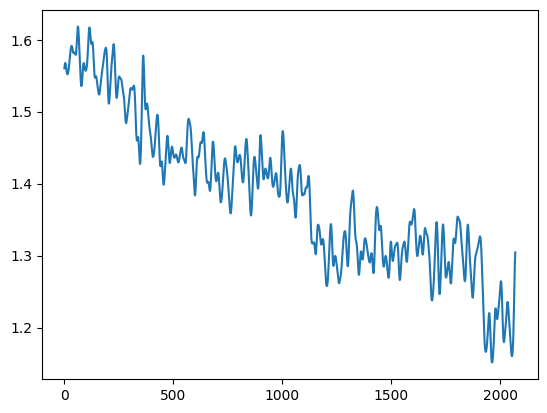

In [17]:
from scipy.ndimage import gaussian_filter

losses_smoothed = gaussian_filter(gaussian_losses, sigma=5)

plt.plot(losses_smoothed)
plt.show()
plt.plot(losses_smoothed[500:])

In [20]:
def test_model(model: nn.Module, testloader: DataLoader) -> float:
    n_correct = 0
    n_total = 512

    for i in tqdm(range(n_total)):
        images, labels = next(iter(testloader))
        images = images.to(device)
        labels = labels.to(device)

        # predict labels
        predictions = model(images)
        n_correct += (predictions.argmax(dim=1) == labels).float().sum()

    accuracy = n_correct/n_total
    return accuracy

In [24]:
trainloader_eval = DataLoader(trainset, batch_size=1, shuffle=True)
testloader_eval = DataLoader(testset, batch_size=1, shuffle=True)

print(f"Train Accuracy: {test_model(conv_model, trainloader_eval)}")
print(f"Test Accuracy: {test_model(conv_model, testloader_eval)}")

100%|██████████| 512/512 [00:01<00:00, 352.35it/s]


Train Accuracy: 0.560546875


100%|██████████| 512/512 [00:00<00:00, 756.60it/s]

Test Accuracy: 0.427734375


In [21]:
trainloader_eval = DataLoader(trainset, batch_size=1, shuffle=True)
testloader_eval = DataLoader(testset, batch_size=1, shuffle=True)

print(f"Train Accuracy: {test_model(gaussian_model, trainloader_eval)}")
print(f"Test Accuracy: {test_model(gaussian_model, testloader_eval)}")

100%|██████████| 512/512 [00:06<00:00, 78.92it/s]


Train Accuracy: 0.53125


100%|██████████| 512/512 [00:05<00:00, 88.38it/s]

Test Accuracy: 0.482421875


# Visualize Convolutional Layers 

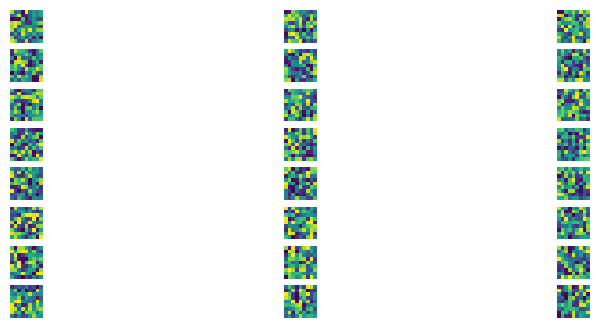

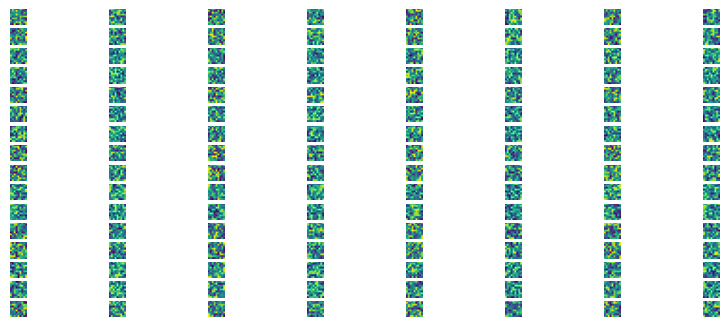

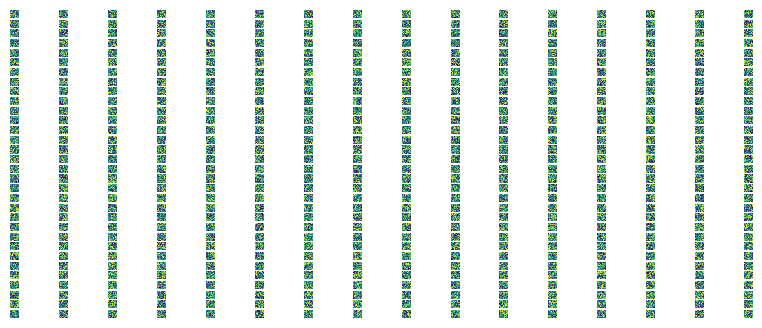

In [25]:
def viz_conv(conv: nn.Conv2d):
    fig, axs = plt.subplots(conv.out_channels, conv.in_channels, figsize=(10, 4))

    for i in range(conv.out_channels):
        for j in range(conv.in_channels):
            axs[i, j].imshow(conv.weight[i, j].detach().cpu().numpy())
            axs[i, j].axis('off')

viz_conv(conv_model.conv1)
viz_conv(conv_model.conv2)
viz_conv(conv_model.conv3)

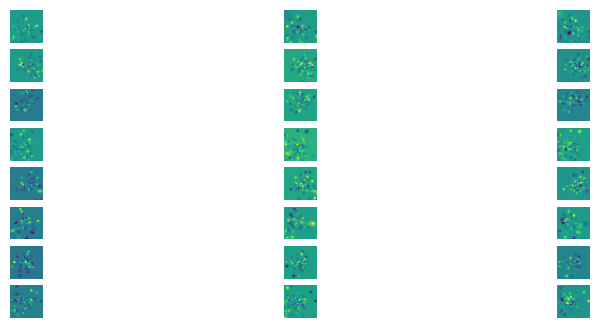

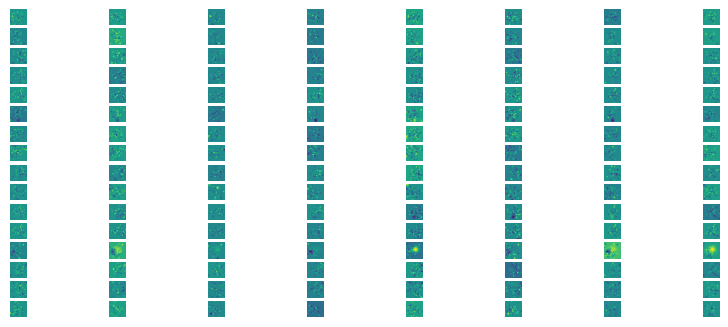

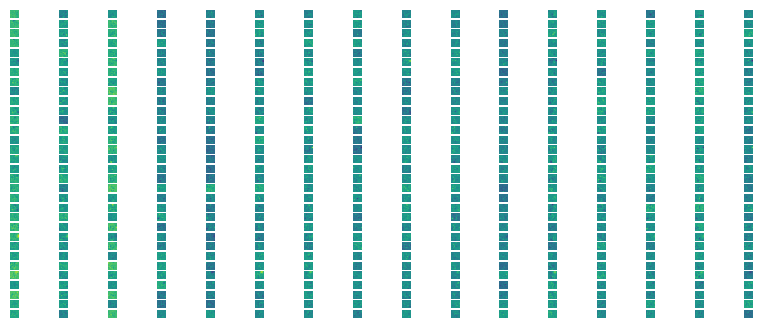

In [18]:
def viz_glayer(glayer: GaussianSplattingLayer):
    # kernel in (out_channels, in_channels, filter_size, filter_size)
    kernel = glayer.renderer(
        glayer.g_mean.expand(glayer.out_channels, glayer.n_gaussians, 3),
        glayer.g_scales.expand(glayer.out_channels, glayer.n_gaussians, 3),
        glayer.g_quats.expand(glayer.out_channels, glayer.n_gaussians, 4),
        glayer.g_colors.expand(glayer.out_channels, glayer.n_gaussians, glayer.in_channels),
        glayer.camera_viewmatrices,
    )

    fig, axs = plt.subplots(glayer.out_channels, glayer.in_channels, figsize=(10, 4))

    for i in range(glayer.out_channels):
        for j in range(glayer.in_channels):
            axs[i, j].imshow(kernel[i, j].detach().cpu().numpy())
            axs[i, j].axis('off')

viz_glayer(gaussian_model.conv1)
viz_glayer(gaussian_model.conv2)
viz_glayer(gaussian_model.conv3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


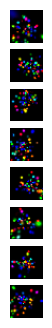

In [28]:
def viz_rgb_glayer(glayer: GaussianSplattingLayer):
    # kernel in (out_channels, in_channels, filter_size, filter_size)
    kernel = glayer.renderer(
        glayer.g_mean.expand(glayer.out_channels, glayer.n_gaussians, 3),
        glayer.g_scales.expand(glayer.out_channels, glayer.n_gaussians, 3),
        glayer.g_quats.expand(glayer.out_channels, glayer.n_gaussians, 4),
        glayer.g_colors.expand(glayer.out_channels, glayer.n_gaussians, glayer.in_channels),
        glayer.camera_viewmatrices,
    )

    fig, axs = plt.subplots(glayer.out_channels, 1, figsize=(4, 4), squeeze=False)

    for i in range(glayer.out_channels):
        axs[i, 0].imshow(kernel[i].detach().cpu().permute(1, 2, 0).numpy())
        axs[i, 0].axis('off')

viz_rgb_glayer(gaussian_model.conv1)